# Proyecto Credit Score - Versión con Transformaciones Logarítmicas

Este notebook aplica limpieza, análisis exploratorio, transformaciones logarítmicas y entrenamiento de un modelo Random Forest para predecir el credit_score.

In [2]:
# 📦 Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
# 📂 Cargar datos y crear variables derivadas
df = pd.read_csv('users_data_10k_extra_semicolon.csv')
df = df.drop(columns=['id', 'address', 'latitude', 'longitude'])
df['gender'] = df['gender'].astype(int)
df['debt_to_income_ratio'] = df['total_debt'] / df['yearly_income']
df['years_to_retirement'] = df['retirement_age'] - df['current_age']

# 🔄 Transformaciones logarítmicas
df['log_yearly_income'] = np.log1p(df['yearly_income'])
df['log_total_debt'] = np.log1p(df['total_debt'])
df['log_per_capita_income'] = np.log1p(df['per_capita_income'])

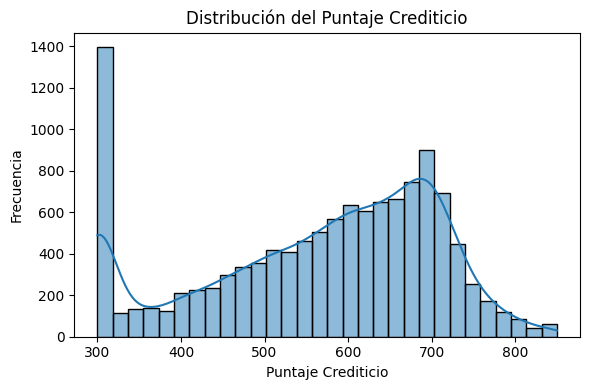

In [4]:
# 📊 EDA: Histograma del credit score
plt.figure(figsize=(6, 4))
sns.histplot(df['credit_score'], bins=30, kde=True)
plt.title('Distribución del Puntaje Crediticio')
plt.xlabel('Puntaje Crediticio')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

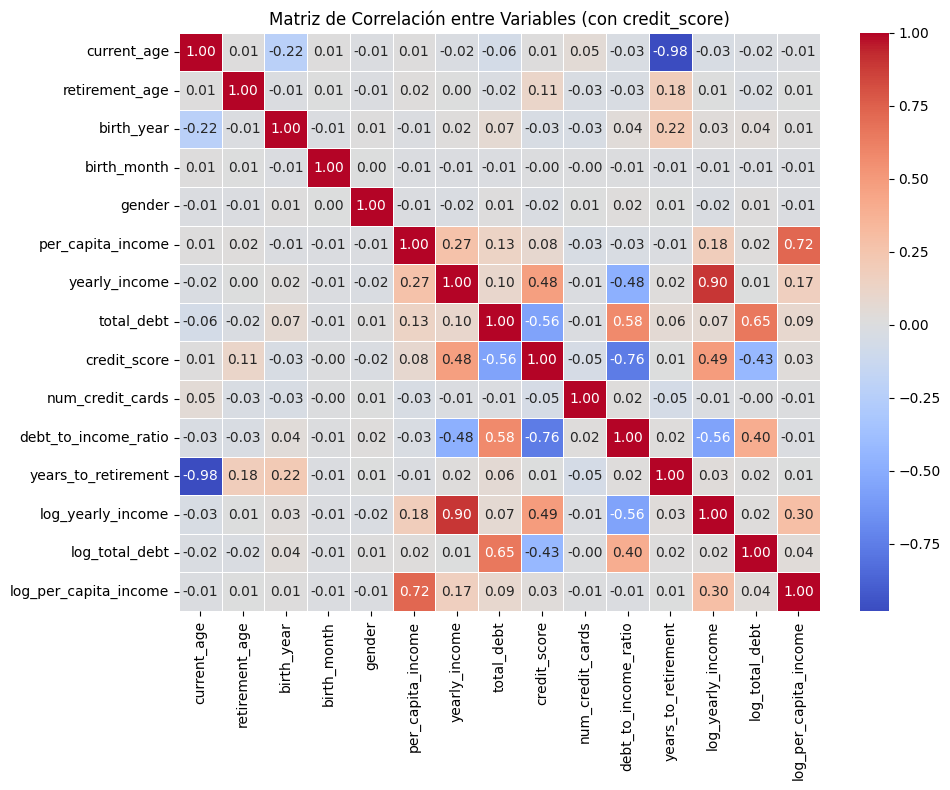

In [5]:
# 🔍 Matriz de correlación incluyendo credit_score
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación entre Variables (con credit_score)')
plt.tight_layout()
plt.show()

In [6]:
# ⚙️ Preparar datos para el modelo
feature_cols = [
    'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender',
    'log_yearly_income', 'log_total_debt', 'log_per_capita_income',
    'num_credit_cards', 'debt_to_income_ratio', 'years_to_retirement']

X = df[feature_cols]
y = df['credit_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 🤖 Entrenar y evaluar Random Forest con validación cruzada
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train_scaled, y_train)


y_pred = model_rf.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R² test: {r2:.4f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

R² test: 0.8684
MAE: 30.94
RMSE: 50.96


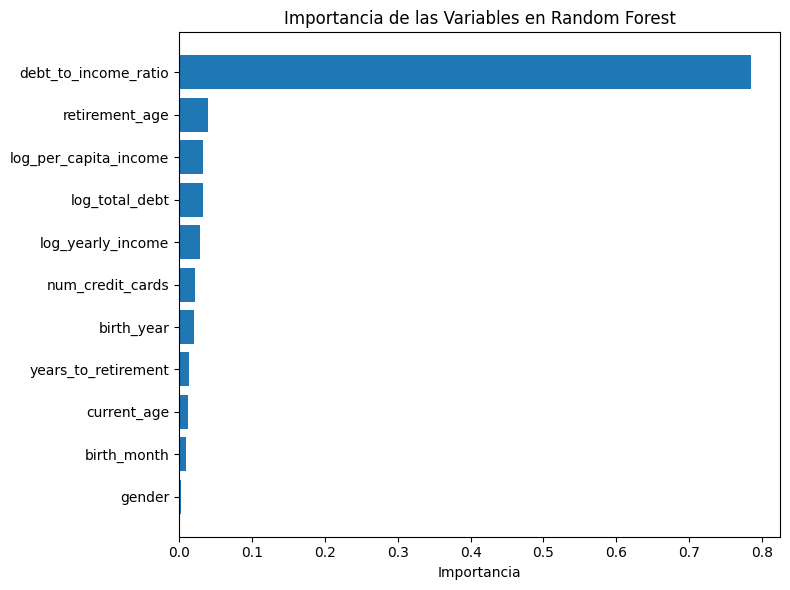

In [8]:
# 📌 Importancia de las variables
importances = model_rf.feature_importances_
features_list = X.columns
sorted_idx = np.argsort(importances)
plt.figure(figsize=(8, 6))
plt.barh(features_list[sorted_idx], importances[sorted_idx])
plt.title('Importancia de las Variables en Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

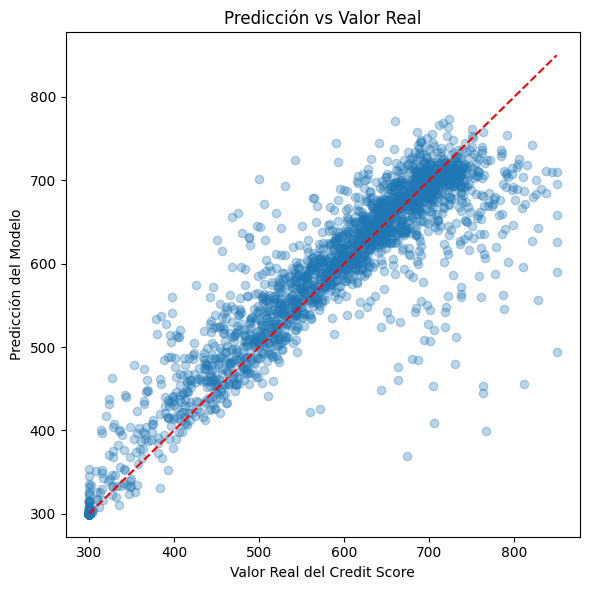

In [9]:
# 📈 Predicción vs. Valor Real
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Valor Real del Credit Score')
plt.ylabel('Predicción del Modelo')
plt.title('Predicción vs Valor Real')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [10]:
# 💳 Función de asignación de límite según el credit score y otros factores
def asignar_limite(row, pred_score):
    if np.isnan(pred_score):
        if row['log_yearly_income'] > 10 and row['debt_to_income_ratio'] < 0.2:
            return 3000  # sin historial, buen ingreso y baja deuda
        else:
            return 1000  # sin historial, baja confianza
    elif pred_score >= 750:
        return 12000
    elif 700 <= pred_score < 750:
        return 8500
    elif 650 <= pred_score < 700:
        return 6000
    else:
        return 2500

In [11]:
# 🧠 Predecir credit_score y asignar límite
df['predicted_score'] = model_rf.predict(scaler.transform(df[feature_cols]))
df['limite_tarjeta'] = df.apply(lambda row: asignar_limite(row, row['predicted_score']), axis=1)

In [12]:
# 📊 Mostrar algunos resultados
df[['credit_score', 'predicted_score', 'log_yearly_income', 'debt_to_income_ratio', 'limite_tarjeta']].head(10)

,credit_score,predicted_score,log_yearly_income,debt_to_income_ratio,limite_tarjeta
0,787.0,562.204119,10.997037,2.137714,2500
1,701.0,713.010000,11.254867,2.476881,8500
2,698.0,707.620000,10.418823,0.005854,8500
3,722.0,714.753209,12.428920,0.809555,8500
4,675.0,690.920000,11.605395,1.676179,6000
5,704.0,713.064196,10.645377,0.000000,8500
6,672.0,669.262763,10.849357,1.986136,6000
7,728.0,704.523560,10.908229,2.100049,8500
8,755.0,720.631412,10.657495,0.068103,8500
9,810.0,721.011039,10.550355,2.127835,8500


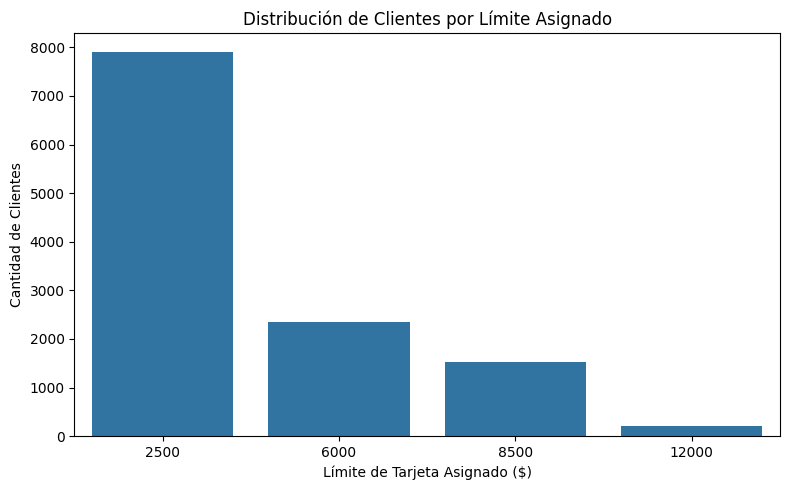

In [13]:
# 📊 Visualizar la distribución de clientes por límite asignado
limite_summary = df['limite_tarjeta'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=limite_summary.index.astype(str), y=limite_summary.values)
plt.title('Distribución de Clientes por Límite Asignado')
plt.xlabel('Límite de Tarjeta Asignado ($)')
plt.ylabel('Cantidad de Clientes')
plt.tight_layout()
plt.show()